In [1]:
import os
import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import TimeseriesGenerator


mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.grid'] = False
plt.style.use('ggplot')

C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


In [2]:

data_2 = pd.read_csv('../output/zero4_outputs.csv')
data_2 = data_2.drop([data_2.columns[0]], axis='columns')
data_2 = data_2.iloc[:, :-3]
data_2.reset_index(drop=True, inplace=True)
# unit='s' to convert it into epoch time
data_2['Time'] = pd.to_datetime(data_2['Time'])

date_time = data_2['Time'].dt.strftime('%S')


# checking our dataframe once again
data_2.head()


,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_49,Subcar_50,Subcar_51,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58
0,1970-01-01 00:00:01.641598542,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,575.782077,520.239368,471.936436,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079
1,1970-01-01 00:00:01.641598543,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,455.247186,423.709806,390.858030,367.766230,339.484904,339.087010,343.083080,343.739727,346.943800,351.039884
2,1970-01-01 00:00:01.641598544,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,672.899695,599.141052,524.108767,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791
3,1970-01-01 00:00:01.641598545,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,610.351538,538.108725,508.141712,459.243944,413.706418,406.503382,392.998728,389.802514,381.072172,390.508643
4,1970-01-01 00:00:01.641598546,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,788.428817,729.188590,698.148981,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355


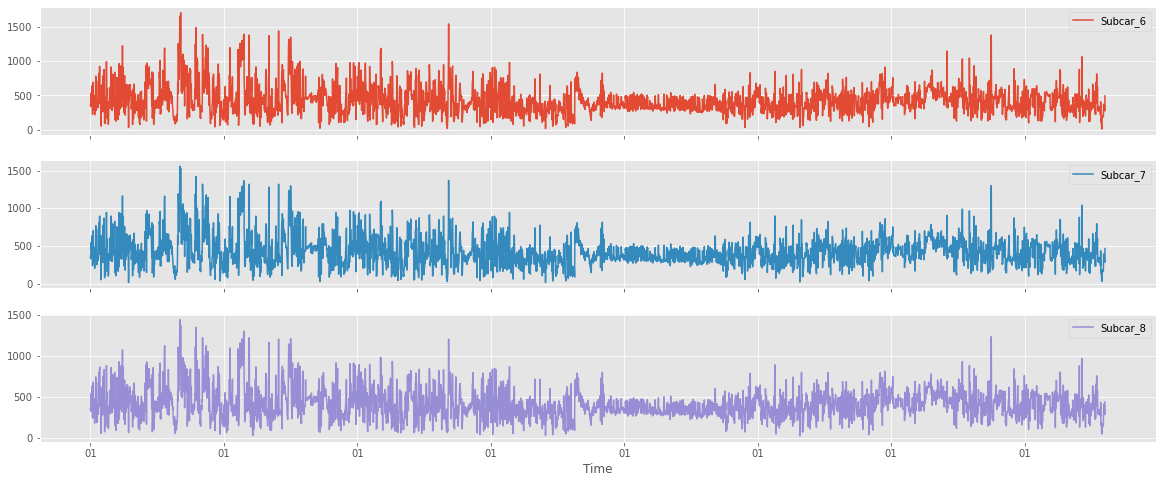

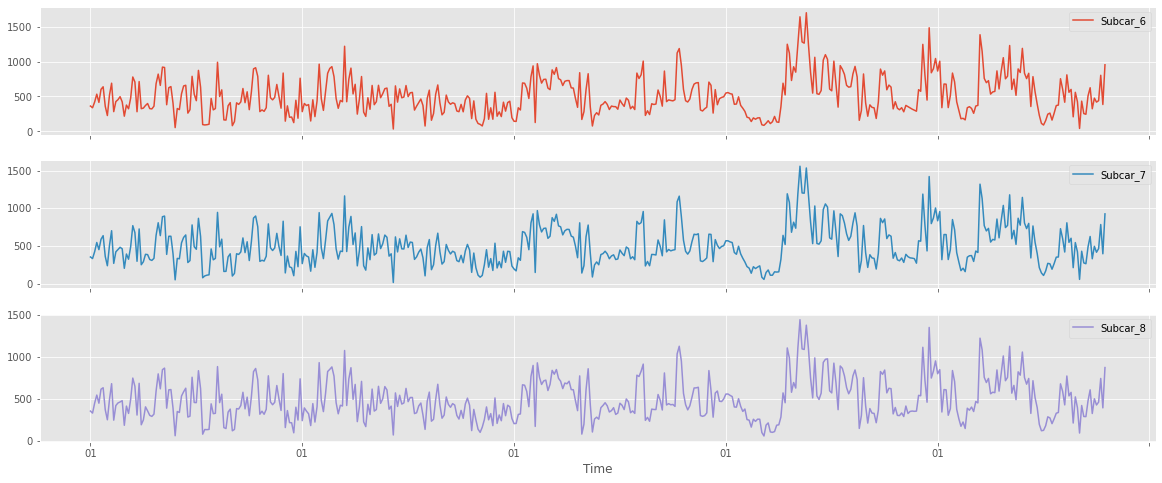

In [3]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_8']
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)
# plt.savefig('../images/raw_data_1.png', dpi=500,)

plot_features = data_2[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)
# plt.savefig('../images/raw_data_2.png', dpi=500,)



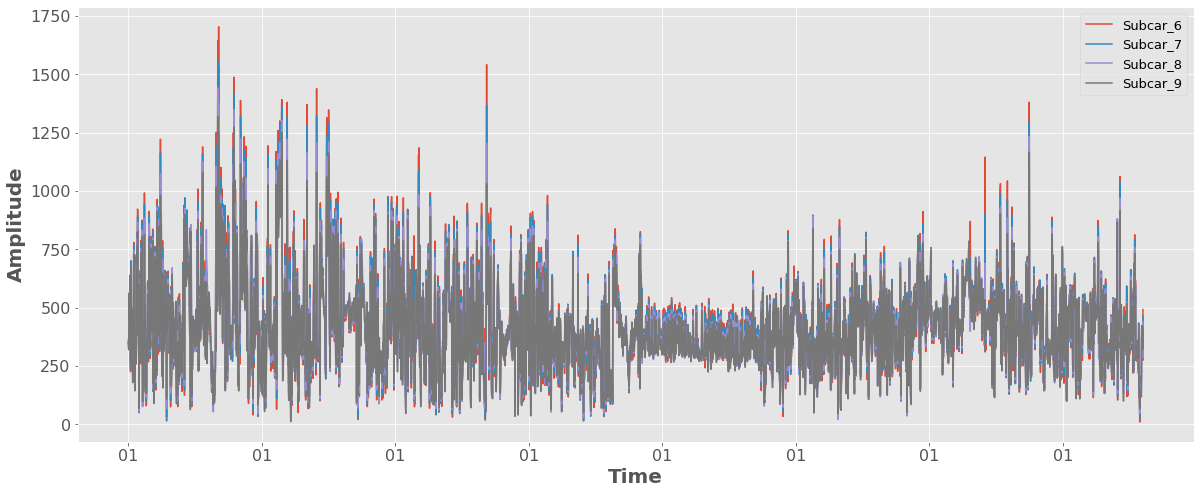

In [4]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_8', 'Subcar_9']
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold', horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=13)
# plt.savefig('../images/raw_data.pdf', dpi=300)


In [5]:
# Set the date column as the index of your DataFrame meat
data_2 = data_2.set_index('Time')

# Print the summary statistics of the DataFrame
print(data_2.describe())


          Subcar_0     Subcar_1     Subcar_2     Subcar_3     Subcar_4  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000   
mean   5482.579092  7455.158795  6233.369403  8730.690589   437.319876   
std     308.541115   114.541341    63.095344   167.604655   494.960094   
min       0.000000  5499.938181  6230.129694  6230.129694     6.000000   
25%    5499.938181  7461.867126  6230.129694  8741.921642   277.672016   
50%    5499.938181  7461.867126  6230.129694  8741.921642   379.214319   
75%    5499.938181  7461.867126  6230.129694  8741.921642   502.360387   
max    5499.938181  7461.867126  7461.867126  8741.921642  8741.921642   

          Subcar_5     Subcar_6     Subcar_7     Subcar_8     Subcar_9  ...  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000  ...   
mean    418.955691   422.932055   422.431979   413.767333   410.627681  ...   
std     208.937454   202.453002   193.543158   181.690717   171.775869  ...   
min       4.24264

In [6]:
df_input = data_2[['Subcar_6', 'Subcar_7', 'Subcar_8', 'Subcar_9']]
df_input.head()


,Subcar_6,Subcar_7,Subcar_8,Subcar_9
Time,,,,
1970-01-01 00:00:01.641598542,362.527240,353.411941,351.432782,353.793725
1970-01-01 00:00:01.641598543,338.013313,332.434956,327.232333,319.820262
1970-01-01 00:00:01.641598544,421.911128,424.001179,447.754397,441.279957
1970-01-01 00:00:01.641598545,533.348854,545.424605,542.492396,562.694411
1970-01-01 00:00:01.641598546,415.226444,450.480854,445.583887,458.423385


In [7]:
df_input.describe()


,Subcar_6,Subcar_7,Subcar_8,Subcar_9
count,3802.000000,3802.000000,3802.000000,3802.000000
mean,422.932055,422.431979,413.767333,410.627681
std,202.453002,193.543158,181.690717,171.775869
min,10.295630,14.764823,24.207437,11.661904
25%,295.032201,300.879956,300.189524,301.906856
50%,391.523942,393.309005,389.432916,387.431284
75%,511.462363,509.395703,500.228934,496.494461
max,1704.556541,1556.767484,1442.231951,1320.984860


In [8]:
df_input.query("Subcar_6 > 600")


,Subcar_6,Subcar_7,Subcar_8,Subcar_9
Time,,,,
1970-01-01 00:00:01.641598547,602.844093,587.749096,612.885797,601.239553
1970-01-01 00:00:01.641598547,639.425523,635.824661,629.924599,631.708794
1970-01-01 00:00:01.641598550,691.112871,701.485567,678.552135,677.784627
1970-01-01 00:00:01.641598556,780.515855,768.584413,745.410625,730.010959
1970-01-01 00:00:01.641598556,708.138405,675.931949,646.845422,620.697189
...,...,...,...,...
1970-01-01 00:00:01.641600092,663.272191,663.451581,634.461189,615.210533
1970-01-01 00:00:01.641600103,615.646814,626.744765,609.397243,609.118215
1970-01-01 00:00:01.641600103,690.676480,678.564662,658.891493,656.966514


In [9]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_input)
data_scaled


array([[-0.29840387, -0.35666007, -0.34312568, -0.33090464],
       [-0.41950433, -0.46505834, -0.47633904, -0.52870851],
       [-0.00504345,  0.00810882,  0.1870846 ,  0.1784669 ],
       ...,
       [-0.27743919, -0.20720092, -0.15398159,  0.07324638],
       [-0.73269987, -0.72525887, -0.70052711, -0.52228415],
       [ 0.34273106,  0.22060855,  0.14296075, -0.015185  ]])

In [10]:
features = data_scaled
target = data_scaled[:, 0]


In [11]:
TimeseriesGenerator(features, target, length=6,
                    sampling_rate=1, batch_size=1)[0]


(array([[[-0.29840387, -0.35666007, -0.34312568, -0.33090464],
         [-0.41950433, -0.46505834, -0.47633904, -0.52870851],
         [-0.00504345,  0.00810882,  0.1870846 ,  0.1784669 ],
         [ 0.54546646,  0.63556266,  0.70857773,  0.88537891],
         [-0.03806624,  0.14494217,  0.17513684,  0.27828118],
         [ 0.88877764,  0.85427387,  1.09606401,  1.1098005 ]]]),
 array([1.06949239]))

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.20, random_state=120, shuffle=False)
print('X_train.shape: ', x_train.shape)
print('X_test.shape: ', x_test.shape)


X_train.shape:  (3041, 4)
X_test.shape:  (761, 4)


In [13]:
win_length = 144  # 1 day = 144 of data, 5 day = 720 of data
batch_size = 32
num_features = 4
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [14]:
train_generator[0]


(array([[[-0.29840387, -0.35666007, -0.34312568, -0.33090464],
         [-0.41950433, -0.46505834, -0.47633904, -0.52870851],
         [-0.00504345,  0.00810882,  0.1870846 ,  0.1784669 ],
         ...,
         [-0.31770112, -0.29853529, -0.22009508, -0.20091622],
         [-0.17366199, -0.13916572, -0.01731661,  0.10073881],
         [-1.93023053, -2.10609108, -1.91410552, -1.75742493]],
 
        [[-0.41950433, -0.46505834, -0.47633904, -0.52870851],
         [-0.00504345,  0.00810882,  0.1870846 ,  0.1784669 ],
         [ 0.54546646,  0.63556266,  0.70857773,  0.88537891],
         ...,
         [-0.17366199, -0.13916572, -0.01731661,  0.10073881],
         [-1.93023053, -2.10609108, -1.91410552, -1.75742493],
         [ 1.13459881,  1.01863711,  0.8513744 ,  0.67052056]],
 
        [[-0.00504345,  0.00810882,  0.1870846 ,  0.1784669 ],
         [ 0.54546646,  0.63556266,  0.70857773,  0.88537891],
         [-0.03806624,  0.14494217,  0.17513684,  0.27828118],
         ...,
       

In [15]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(
        win_length, num_features), return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, 'linear')
])

lstm_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 144, 128)          68096     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 144, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 144, 128)          131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 144, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 144, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [16]:
cp1 = ModelCheckpoint('../save/lstm_model_standard/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}

In [17]:
history = lstm_model.fit(
    train_generator, epochs=15,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp1 ])


Epoch 1/15
91/91 [==============================] - ETA: 0s - loss: 0.9600 - mean_absolute_error: 0.7143WARNING:tensorflow:From C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../save/lstm_model_standard\assets
91/91 [==============================] - 24s 268ms/step - loss: 0.9600 - mean_absolute_error: 0.7143 - val_loss: 0.5980 - val_mean_absolute_error: 0.5789
Epoch 2/15
91/91 [==============================] - 24s 261ms/step - loss: 0.8919 - mean_absolute_error: 0.6881 - val_loss: 0.5795 - val_mean_absolute_error: 0.5666
Epoch 3/15
9

In [18]:
lstm_eval = lstm_model.evaluate(
    test_generator, verbose=0
)
lstm_eval
val_performance['LSTM'] = lstm_model.evaluate(train_generator)
performance['LSTM'] = lstm_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 7s 75ms/step - loss: 0.8008 - mean_absolute_error: 0.6403


In [19]:
predictions_lstm = lstm_model.predict(test_generator)

In [20]:
from tensorflow.keras.models import load_model
gru_model = load_model('../save/lstm_model_standard/')

In [21]:
predictions_lstm.shape[0]


617

In [22]:
predictions_lstm


array([[ 2.42188007e-01],
       [ 3.53067815e-01],
       [ 4.82840002e-01],
       [ 4.96699423e-01],
       [ 5.62067509e-01],
       [ 3.35928261e-01],
       [ 2.03077868e-01],
       [ 2.29567856e-01],
       [ 3.53438318e-01],
       [ 3.65515858e-01],
       [ 2.71205992e-01],
       [ 3.41182768e-01],
       [ 3.98760885e-01],
       [ 1.80575728e-01],
       [-9.89058614e-03],
       [-2.66720057e-02],
       [ 2.39642672e-02],
       [ 1.71486691e-01],
       [ 2.53887028e-01],
       [ 1.45008862e-01],
       [ 1.62020117e-01],
       [ 8.31318200e-02],
       [ 4.15146537e-02],
       [-7.69205391e-02],
       [-8.19063783e-02],
       [ 4.96095091e-01],
       [-7.45426863e-02],
       [-1.41481847e-01],
       [-1.93554819e-01],
       [-7.70771503e-02],
       [-4.07784022e-02],
       [-1.89318508e-02],
       [ 8.19049776e-04],
       [ 4.85989489e-02],
       [ 7.78528154e-02],
       [ 1.03152707e-01],
       [ 1.39482468e-02],
       [-2.65662223e-02],
       [ 3.8

In [23]:
y_test


array([-2.23392455e-01,  2.60466969e-01,  3.04683782e-01, -3.79392915e-01,
       -2.87156246e-01, -2.87975706e-01, -3.00128488e-01, -2.92581092e-01,
       -2.50479368e-01, -1.00799095e+00, -8.43377374e-01,  4.89444939e-01,
       -6.68521687e-01, -4.71186287e-01,  4.76061840e-01,  4.32817763e-01,
       -1.55416865e-01,  8.45012376e-01,  1.09786157e+00, -8.75551265e-02,
       -2.33234157e-01, -9.43267223e-02, -8.34447427e-02,  9.86747017e-01,
        3.90094148e-01, -5.58370143e-01,  3.41692396e-02,  5.66560401e-01,
       -5.54350399e-01, -7.17058563e-01, -3.06660276e-01, -8.01659913e-01,
       -5.87914333e-01, -6.02278754e-01, -3.57179843e-01, -3.77274810e-01,
       -2.31236691e-01, -3.10332942e-01,  3.96419909e-01,  3.11915656e-01,
       -1.69252861e-01, -1.03713012e-01, -5.99737163e-01, -2.87156246e-01,
        5.29039403e-01,  2.19475101e-01,  3.07251279e-01, -5.71160172e-01,
        1.36296029e+00, -1.29876322e+00,  3.95855326e-01, -5.45820473e-01,
        2.99050096e-01,  

In [24]:
x_test


array([[-0.22339246, -0.17800668, -0.13104803, -0.09350367],
       [ 0.26046697,  0.29052298,  0.33157891,  0.36036737],
       [ 0.30468378,  0.40193209,  0.34824829,  0.43489046],
       ...,
       [-0.27743919, -0.20720092, -0.15398159,  0.07324638],
       [-0.73269987, -0.72525887, -0.70052711, -0.52228415],
       [ 0.34273106,  0.22060855,  0.14296075, -0.015185  ]])

In [25]:
x_test[:, 1:][win_length:]


array([[ 1.0241705 ,  1.18165347,  1.22346867],
       [ 1.29962917,  1.68203068,  1.64645577],
       [ 1.25468271,  1.39370489,  1.4411265 ],
       ...,
       [-0.20720092, -0.15398159,  0.07324638],
       [-0.72525887, -0.70052711, -0.52228415],
       [ 0.22060855,  0.14296075, -0.015185  ]])

In [26]:
df_pred_lstm = pd.concat([pd.DataFrame(predictions_lstm),
                    pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_lstm


,0,0,1,2
0,0.242188,1.024170,1.181653,1.223469
1,0.353068,1.299629,1.682031,1.646456
2,0.482840,1.254683,1.393705,1.441127
3,0.496699,1.428023,1.518551,1.610747
4,0.562068,0.593265,0.585529,0.664491
...,...,...,...,...
612,-0.351778,-0.139950,-0.002518,0.078249
613,-0.180625,-0.213699,-0.106270,-0.033622
614,-0.145653,-0.207201,-0.153982,0.073246
615,-0.141130,-0.725259,-0.700527,-0.522284


In [27]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred_lstm)
rev_trans


array([[471.95729576, 620.6271022 , 628.434563  , 620.7624344 ],
       [494.4022936 , 673.9332311 , 719.3364998 , 693.4118545 ],
       [520.67160697, 665.2352967 , 666.95727   , 658.1458805 ],
       ...,
       [393.44809267, 382.3349317 , 385.7939865 , 423.2079867 ],
       [394.36354533, 282.0815485 , 286.5047993 , 320.9236669 ],
       [368.27337825, 465.1236395 , 439.7385587 , 408.0196074 ]])

In [28]:
df_final_lstm = df_input[predictions_lstm.shape[0]*-1:]


In [29]:
df_final_lstm.count()


Subcar_6    617
Subcar_7    617
Subcar_8    617
Subcar_9    617
dtype: int64

In [33]:
df_final_lstm['Subcar_6_pred'] = rev_trans[:, 0]
df_final_lstm


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_8,Subcar_9,Subcar_8_pred,Subcar_6_pred
Time,,,,,,
1970-01-01 00:00:01.641599862,603.491508,620.627102,628.434563,620.762434,471.957296,471.957296
1970-01-01 00:00:01.641599862,647.734514,673.933231,719.336500,693.411855,494.402294,494.402294
1970-01-01 00:00:01.641599862,656.558451,665.235297,666.957270,658.145880,520.671607,520.671607
1970-01-01 00:00:01.641599862,703.184186,698.779651,689.637586,687.278692,523.477119,523.477119
1970-01-01 00:00:01.641599862,547.154457,537.239239,520.138443,524.756134,536.709344,536.709344
...,...,...,...,...,...,...
1970-01-01 00:00:01.641600115,369.043358,395.349213,413.309811,424.067212,351.722885,351.722885
1970-01-01 00:00:01.641600115,362.663756,381.077420,394.461658,404.853060,386.368775,386.368775
1970-01-01 00:00:01.641600115,366.771046,382.334932,385.793987,423.207987,393.448093,393.448093


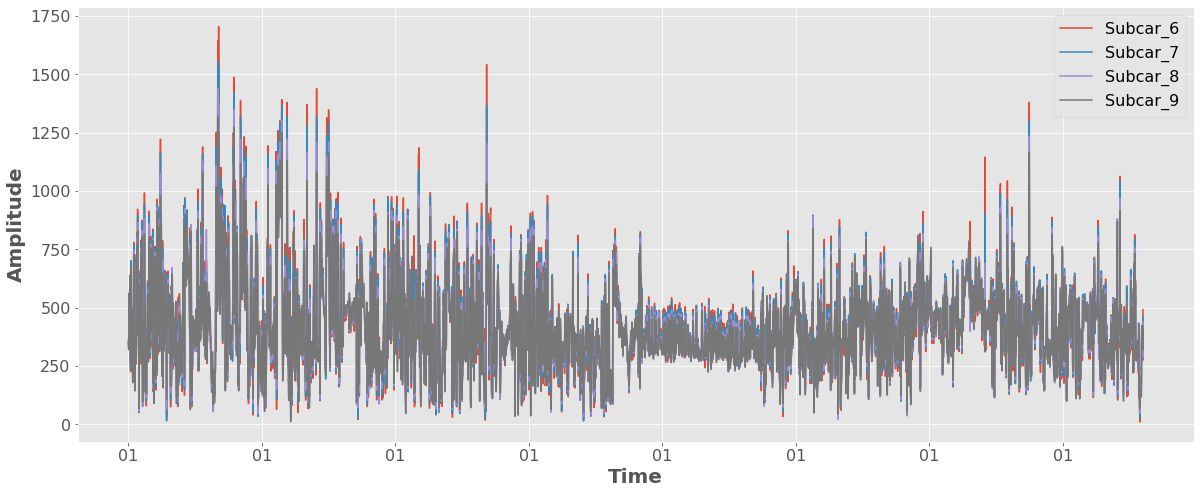

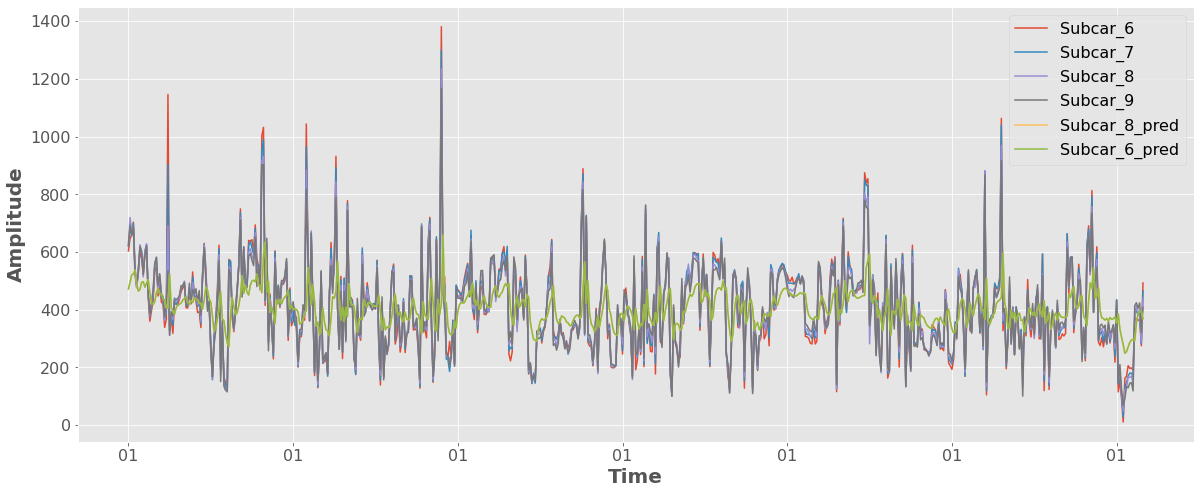

In [34]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_8', 'Subcar_9']
plot_features = df_input[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# plt.savefig('../images/raw_standard.png', dpi=500)


df_final_lstm[['Subcar_6', 'Subcar_6_pred']]
df_final_lstm.index = date_time[:617]
_ = df_final_lstm.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# plt.savefig('../images/pred_standard.png', dpi=500)


In [35]:
gru_model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        128, input_shape=(win_length, num_features), return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])


In [36]:
cp3 = ModelCheckpoint('../save/gru_model_standard/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
gru_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [37]:
history_2 = gru_model.fit(
    train_generator, epochs=10,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping
               , cp3])


Epoch 1/10
91/91 [==============================] - 35s 388ms/step - loss: 1.0131 - mean_absolute_error: 0.7401 - val_loss: 0.5988 - val_mean_absolute_error: 0.5901
Epoch 2/10
91/91 [==============================] - 31s 338ms/step - loss: 0.8972 - mean_absolute_error: 0.6913 - val_loss: 0.5871 - val_mean_absolute_error: 0.5736
Epoch 3/10
91/91 [==============================] - 43s 472ms/step - loss: 0.8452 - mean_absolute_error: 0.6689 - val_loss: 0.5736 - val_mean_absolute_error: 0.5614
Epoch 4/10
91/91 [==============================] - 45s 496ms/step - loss: 0.8135 - mean_absolute_error: 0.6548 - val_loss: 0.5667 - val_mean_absolute_error: 0.5542
Epoch 5/10
91/91 [==============================] - 41s 447ms/step - loss: 0.7956 - mean_absolute_error: 0.6455 - val_loss: 0.5647 - val_mean_absolute_error: 0.5525
Epoch 6/10
91/91 [==============================] - 42s 464ms/step - loss: 0.7829 - mean_absolute_error: 0.6386 - val_loss: 0.5630 - val_mean_absolute_error: 0.5518
Epoch 7/10

In [38]:
from tensorflow.keras.models import load_model
gru_model = load_model('../save/gru_model_standard/')

In [39]:
gru_eval = gru_model.evaluate(
    test_generator, verbose=0
)
gru_eval
val_performance['BiLSTM'] = lstm_model.evaluate(train_generator)
performance['BiLSTM'] = lstm_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 14s 153ms/step - loss: 0.8008 - mean_absolute_error: 0.6403


In [40]:
predictions_gru = gru_model.predict(test_generator)
predictions_gru

array([[ 0.23848449],
       [ 0.34864137],
       [ 0.49600154],
       [ 0.57528585],
       [ 0.6628032 ],
       [ 0.52636784],
       [ 0.36605084],
       [ 0.32677373],
       [ 0.397472  ],
       [ 0.42506406],
       [ 0.3546681 ],
       [ 0.3982332 ],
       [ 0.45993438],
       [ 0.2744481 ],
       [ 0.08718892],
       [ 0.03475166],
       [ 0.04319179],
       [ 0.14194663],
       [ 0.23830618],
       [ 0.18719797],
       [ 0.1998549 ],
       [ 0.1383302 ],
       [ 0.09446037],
       [ 0.00899746],
       [-0.01207751],
       [ 0.48238674],
       [ 0.19752057],
       [ 0.09674823],
       [ 0.0104769 ],
       [ 0.0360539 ],
       [ 0.04058679],
       [ 0.05289852],
       [ 0.06118603],
       [ 0.09932321],
       [ 0.13011307],
       [ 0.1593246 ],
       [ 0.06995846],
       [ 0.00810346],
       [ 0.04592185],
       [ 0.00273114],
       [ 0.07993137],
       [ 0.05479562],
       [ 0.03110244],
       [-0.02993065],
       [-0.04810045],
       [-0

In [41]:
predictions_gru.shape[0]


617

In [42]:
predictions_gru

array([[ 0.23848449],
       [ 0.34864137],
       [ 0.49600154],
       [ 0.57528585],
       [ 0.6628032 ],
       [ 0.52636784],
       [ 0.36605084],
       [ 0.32677373],
       [ 0.397472  ],
       [ 0.42506406],
       [ 0.3546681 ],
       [ 0.3982332 ],
       [ 0.45993438],
       [ 0.2744481 ],
       [ 0.08718892],
       [ 0.03475166],
       [ 0.04319179],
       [ 0.14194663],
       [ 0.23830618],
       [ 0.18719797],
       [ 0.1998549 ],
       [ 0.1383302 ],
       [ 0.09446037],
       [ 0.00899746],
       [-0.01207751],
       [ 0.48238674],
       [ 0.19752057],
       [ 0.09674823],
       [ 0.0104769 ],
       [ 0.0360539 ],
       [ 0.04058679],
       [ 0.05289852],
       [ 0.06118603],
       [ 0.09932321],
       [ 0.13011307],
       [ 0.1593246 ],
       [ 0.06995846],
       [ 0.00810346],
       [ 0.04592185],
       [ 0.00273114],
       [ 0.07993137],
       [ 0.05479562],
       [ 0.03110244],
       [-0.02993065],
       [-0.04810045],
       [-0

In [43]:
df_pred_gru = pd.concat([pd.DataFrame(predictions_gru),
                    pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_gru

,0,0,1,2
0,0.238484,1.024170,1.181653,1.223469
1,0.348641,1.299629,1.682031,1.646456
2,0.496002,1.254683,1.393705,1.441127
3,0.575286,1.428023,1.518551,1.610747
4,0.662803,0.593265,0.585529,0.664491
...,...,...,...,...
612,-0.401776,-0.139950,-0.002518,0.078249
613,-0.253672,-0.213699,-0.106270,-0.033622
614,-0.188509,-0.207201,-0.153982,0.073246
615,-0.163422,-0.725259,-0.700527,-0.522284


In [44]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred_gru)
rev_trans


array([[471.20760568, 620.6271022 , 628.434563  , 620.7624344 ],
       [493.50626346, 673.9332311 , 719.3364998 , 693.4118545 ],
       [523.33584983, 665.2352967 , 666.95727   , 658.1458805 ],
       ...,
       [384.77283694, 382.3349317 , 385.7939865 , 423.2079867 ],
       [389.85116453, 282.0815485 , 286.5047993 , 320.9236669 ],
       [364.67100855, 465.1236395 , 439.7385587 , 408.0196074 ]])

In [45]:
df_final_gru = df_input[predictions_gru.shape[0]*-1:]

In [46]:
df_final_gru['Subcar_6_pred'] = rev_trans[:, 0]
df_final_gru


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_8,Subcar_9,Subcar_6_pred
Time,,,,,
1970-01-01 00:00:01.641599862,603.491508,620.627102,628.434563,620.762434,471.207606
1970-01-01 00:00:01.641599862,647.734514,673.933231,719.336500,693.411855,493.506263
1970-01-01 00:00:01.641599862,656.558451,665.235297,666.957270,658.145880,523.335850
1970-01-01 00:00:01.641599862,703.184186,698.779651,689.637586,687.278692,539.385085
1970-01-01 00:00:01.641599862,547.154457,537.239239,520.138443,524.756134,557.100900
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,369.043358,395.349213,413.309811,424.067212,341.601974
1970-01-01 00:00:01.641600115,362.663756,381.077420,394.461658,404.853060,371.582205
1970-01-01 00:00:01.641600115,366.771046,382.334932,385.793987,423.207987,384.772837


In [47]:

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(2,),
                           activation='relu', input_shape=(win_length, num_features)),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [48]:
cp4 = ModelCheckpoint('../save/conv_model_standard/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
conv_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [49]:
history_3 = conv_model.fit(
    train_generator, epochs=15,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp4])


Epoch 1/15
91/91 [==============================] - 1s 12ms/step - loss: 1.0743 - mean_absolute_error: 0.7733 - val_loss: 0.6485 - val_mean_absolute_error: 0.6141
Epoch 2/15
91/91 [==============================] - 1s 11ms/step - loss: 1.1067 - mean_absolute_error: 0.7732 - val_loss: 0.6421 - val_mean_absolute_error: 0.6140
Epoch 3/15
91/91 [==============================] - 1s 12ms/step - loss: 1.1041 - mean_absolute_error: 0.7707 - val_loss: 0.6383 - val_mean_absolute_error: 0.6138
Epoch 4/15
91/91 [==============================] - 1s 11ms/step - loss: 1.0972 - mean_absolute_error: 0.7682 - val_loss: 0.6373 - val_mean_absolute_error: 0.6140
Epoch 5/15
91/91 [==============================] - 1s 11ms/step - loss: 1.0943 - mean_absolute_error: 0.7671 - val_loss: 0.6368 - val_mean_absolute_error: 0.6142
Epoch 6/15
91/91 [==============================] - 1s 11ms/step - loss: 1.0920 - mean_absolute_error: 0.7662 - val_loss: 0.6365 - val_mean_absolute_error: 0.6145
Epoch 7/15
91/91 [====

In [50]:
from tensorflow.keras.models import load_model
gru_model = load_model('../save/conv_model_standard/')


In [51]:
conv_eval = conv_model.evaluate(
    test_generator, verbose=0
)
conv_eval
val_performance['CONV'] = lstm_model.evaluate(train_generator)
performance['CONV'] = lstm_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 14s 151ms/step - loss: 0.8008 - mean_absolute_error: 0.6403


In [52]:
predictions_conv = conv_model.predict(test_generator)
predictions_conv

array([[[-0.09644786],
        [-0.04650019],
        [-0.09982689],
        ...,
        [-0.03416033],
        [-0.04415179],
        [-0.03059588]],

       [[-0.04650019],
        [-0.09982689],
        [-0.07794936],
        ...,
        [-0.04415179],
        [-0.03059588],
        [-0.01857297]],

       [[-0.09982689],
        [-0.07794936],
        [-0.07465665],
        ...,
        [-0.03059588],
        [-0.01857297],
        [ 0.02665539]],

       ...,

       [[-0.0517741 ],
        [-0.13247395],
        [-0.15311097],
        ...,
        [-0.15785795],
        [-0.06506469],
        [-0.06312689]],

       [[-0.13247395],
        [-0.15311097],
        [-0.09082521],
        ...,
        [-0.06506469],
        [-0.06312689],
        [-0.06852566]],

       [[-0.15311097],
        [-0.09082521],
        [-0.11011928],
        ...,
        [-0.06312689],
        [-0.06852566],
        [-0.08734109]]], dtype=float32)

In [53]:
df_pred_conv = pd.concat([pd.DataFrame(predictions_gru),
                         pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_conv


,0,0,1,2
0,0.238484,1.024170,1.181653,1.223469
1,0.348641,1.299629,1.682031,1.646456
2,0.496002,1.254683,1.393705,1.441127
3,0.575286,1.428023,1.518551,1.610747
4,0.662803,0.593265,0.585529,0.664491
...,...,...,...,...
612,-0.401776,-0.139950,-0.002518,0.078249
613,-0.253672,-0.213699,-0.106270,-0.033622
614,-0.188509,-0.207201,-0.153982,0.073246
615,-0.163422,-0.725259,-0.700527,-0.522284


In [54]:
# To the original format
rev_trans_conv = scaler.inverse_transform(df_pred_conv)
rev_trans_conv


array([[471.20760568, 620.6271022 , 628.434563  , 620.7624344 ],
       [493.50626346, 673.9332311 , 719.3364998 , 693.4118545 ],
       [523.33584983, 665.2352967 , 666.95727   , 658.1458805 ],
       ...,
       [384.77283694, 382.3349317 , 385.7939865 , 423.2079867 ],
       [389.85116453, 282.0815485 , 286.5047993 , 320.9236669 ],
       [364.67100855, 465.1236395 , 439.7385587 , 408.0196074 ]])

In [55]:
df_final_conv = df_input[predictions_conv.shape[0]*-1:]


In [57]:
df_final_conv['Subcar_6_pred'] = rev_trans_conv[:, 0]
df_final_conv


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_8,Subcar_9,Subcar_6_pred
Time,,,,,
1970-01-01 00:00:01.641599862,603.491508,620.627102,628.434563,620.762434,471.207606
1970-01-01 00:00:01.641599862,647.734514,673.933231,719.336500,693.411855,493.506263
1970-01-01 00:00:01.641599862,656.558451,665.235297,666.957270,658.145880,523.335850
1970-01-01 00:00:01.641599862,703.184186,698.779651,689.637586,687.278692,539.385085
1970-01-01 00:00:01.641599862,547.154457,537.239239,520.138443,524.756134,557.100900
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,369.043358,395.349213,413.309811,424.067212,341.601974
1970-01-01 00:00:01.641600115,362.663756,381.077420,394.461658,404.853060,371.582205
1970-01-01 00:00:01.641600115,366.771046,382.334932,385.793987,423.207987,384.772837


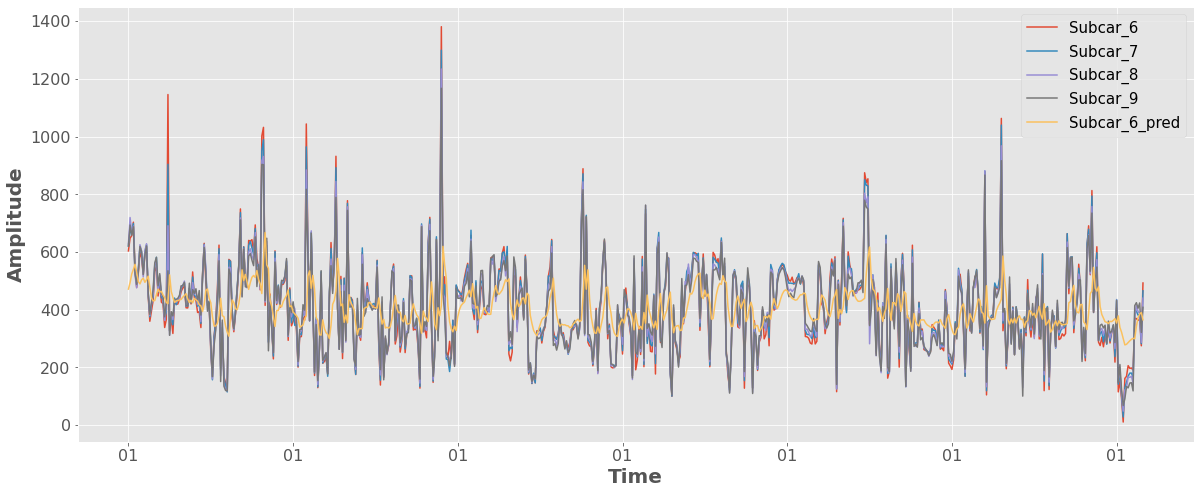

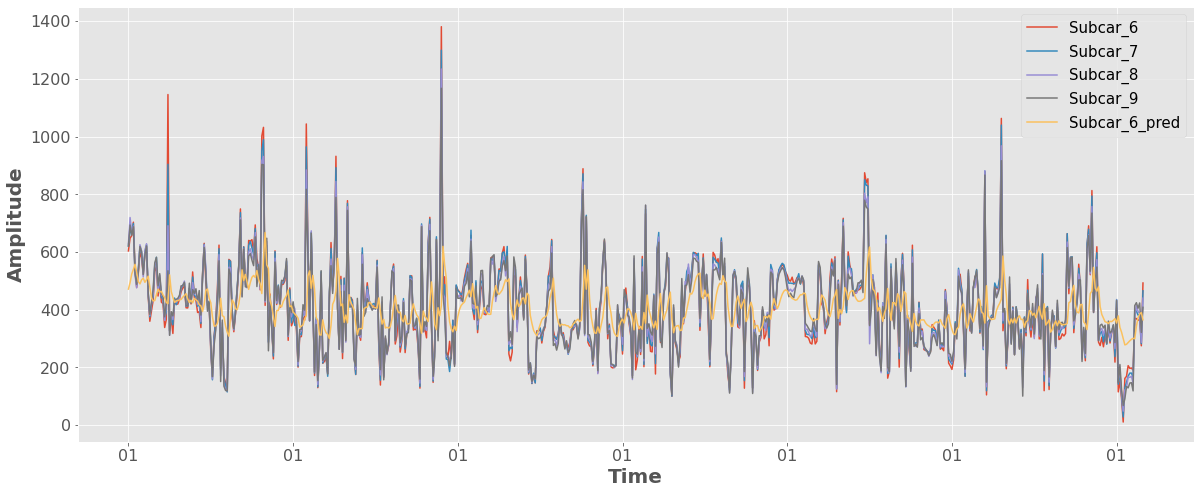

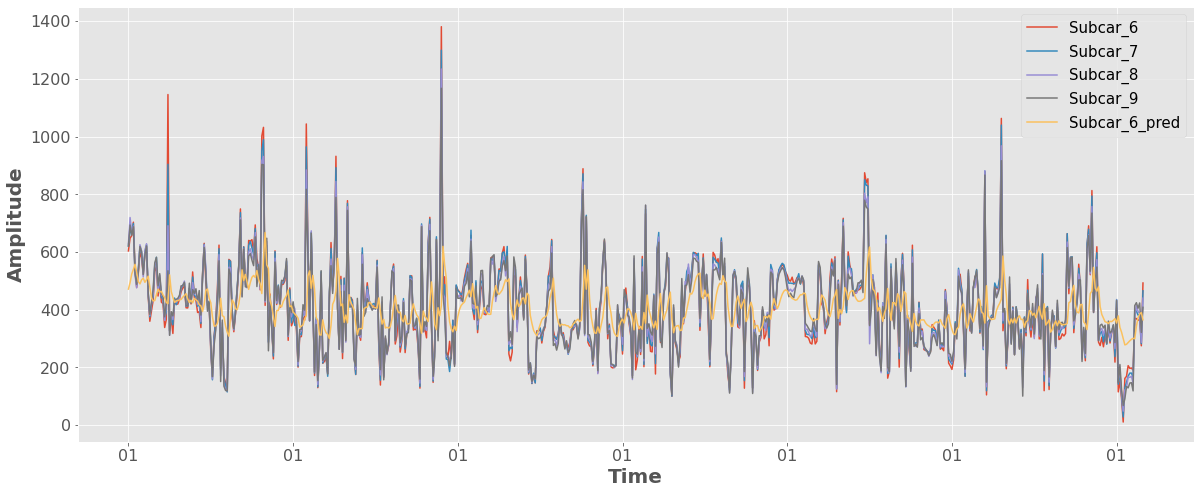

In [58]:

df_final_gru[['Subcar_6', 'Subcar_6_pred']]
df_final_gru.index = date_time[:617]
_ = df_final_gru.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
            horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/lstm_curve_standard.eps', dpi=300)

df_final_gru[['Subcar_6', 'Subcar_6_pred']]
df_final_gru.index = date_time[:617]
_ = df_final_gru.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/gru_curve_standard.eps', dpi=300)

df_final_conv[['Subcar_6', 'Subcar_6_pred']]
df_final_conv.index = date_time[:617]
_ = df_final_conv.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/conv_curve_standard.eps', dpi=300)


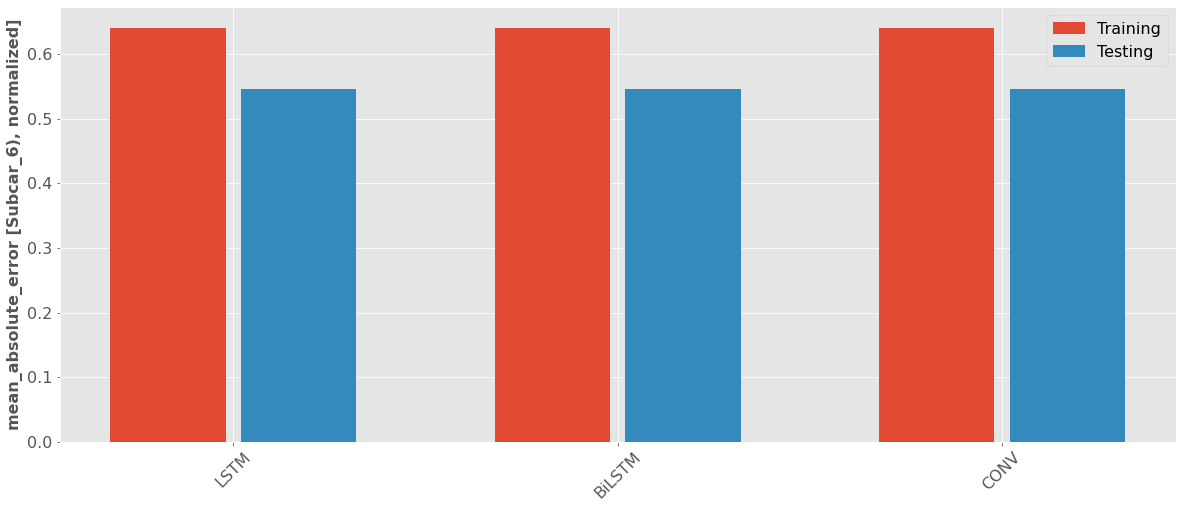

In [59]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Subcar_6), normalized]',
           fontsize=16, fontweight='bold', horizontalalignment='center')
plt.bar(x - 0.17, val_mae, width, label='Training')
plt.bar(x + 0.17, test_mae, width, label='Testing')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45, fontsize=16)
plt.yticks(fontsize=16)
_ = plt.legend(fontsize=16)
# plt.savefig('../images/bar_graph_standard.pdf', dpi=500)


In [60]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


LSTM        : 0.5463
BiLSTM      : 0.5463
CONV        : 0.5463


In [61]:
# df_final_conv[['Subcar_7', 'Subcar_7_pred']].plot()
for name, value in val_performance.items():
      print(f'{name:12s}: {value[1]:0.4f}')


LSTM        : 0.6403
BiLSTM      : 0.6403
CONV        : 0.6403
